# Data Set Generation

Since it is now possible to create random initial mass fractions, the next step is to use them as initial conditions for the needed source term differential equations. By passing this initial conditions to an ODE solver, a sample data set can be created by using them as _input_ vector, an parsing their evolution for a given time to an _output_ array. 

## __Setting the work environment__

The libraries that will be used for this are:

* Cantera
* Numpy
* Pandas
* SciPy

It is also necessary to collect the functions previously defined for producing the initial mass fractions:

In [10]:
import numpy as np
import cantera as ct
import pandas as pd
import scipy
from scipy import integrate
from scipy.optimize import nnls 
#Set printing format for numpy arrays for ease of reading
np.set_printoptions(formatter={'float': lambda x: "{0:0.4f}".format(x)})

In [11]:
#Noble gases filter:
def noble_filter(elements):
    filter_elements=[]
    # List of elements to be removed
    noble=['Ar','Kr','Ne','He','Rn','Xe']
    for x in elements:
        if (noble.count(x)==0):
            filter_elements.append(x)
            
    return filter_elements

#Matrix for the linear system of Equations:
def bilger_matrix(gas):
    
    #Elements present in the mechanism
    elements=noble_filter(gas.element_names)
    #Species present in the mechanism
    species=gas.species_names
    
    #Matrix to store coeffiecients
    A=np.ones((len(elements)+1,len(species)))
   
    row=1;
    for x in elements:
        col=0
        for y in species:
            A[row,col]=gas.n_atoms(y,x)*gas.atomic_weight(x)/gas[y].molecular_weights[0]
            col +=1
        row +=1
    return np.copy(A)

#Vector for the linear system of Equations:

def bilger_vector(f_mix, fuel_dict, oxy_dict, elements):
    
    b=np.ones(len(elements)+1)
    row=1
    for x in elements:
        b[row]=f_mix*fuel_dict[x]+(1-f_mix)*oxy_dict[x]
        row+=1
    return np.copy(b)

# Define a function to Generate random temperatures and mass fractions

def TY_Generator(seed,samples,gas,fuel_dict,oxy_dict,f_max=0.6,f_min=0.1,T_max=3000,T_min=300):
    S=[]
    F=[]
    A=bilger_matrix(gas)
    np.random.seed(seed)
    T=np.random.random(samples)*(T_max-T_min)+T_min
    np.random.seed(seed)
    for i in range(samples):
        f=np.random.random(1)*(f_max-f_min)+f_min
        b=bilger_vector(f[0],fuel_dict, oxy_dict, noble_filter(gas.element_names))
        z=np.linalg.lstsq(A, b,rcond=None)[0:]
        if (z[0][0]>=0):
            S.append(z[0])
        else:
            z,rnorm=nnls(A,b)
            S.append(z)
    YInit=np.array(S)
    return (np.copy(T),np.copy(YInit))

A class called ReactorSolver will also be created in order to provide solutions for the source term ODE's and collect their data points.

In [12]:
#Reactor solver
class ReactorOde(object):
    def __init__(self, gas):
        # Parameters of the ODE system and auxiliary data are stored in the
        # ReactorOde object.
        self.gas = gas
        self.P = gas.P

    def __call__(self, t, y):
        """the ODE function, y' = f(t,y) """

        # State vector is [T, Y_1, Y_2, ... Y_K]
        self.gas.set_unnormalized_mass_fractions(y[1:])
        self.gas.TP = y[0], self.P
        rho = self.gas.density

        wdot = self.gas.net_production_rates
        dTdt = - (np.dot(self.gas.partial_molar_enthalpies, wdot) /
                  (rho * self.gas.cp))
        dYdt = wdot * self.gas.molecular_weights / rho

        return np.hstack((dTdt, dYdt))

To begin, the initial parameters for the data set generations are specified

In [13]:
#Define a function to create the appropiate file tree:
def file_base(base_directory='../'):
    import shutil
    import os
    try:
        #shutil.rmtree((base_directory+'data'), ignore_errors=False, onerror=None)
        os.mkdir((base_directory+'data'))
    except IOError:
        pass
        #os.mkdir((base_directory+'data'))
    
    
#Define a function to create a dataset sample folder structure
def data_folder(samples,step, base_directory='../'):
    import shutil
    import os
    
    try:
        shutil.rmtree((base_directory+'data/'+str(samples)+'_'+str(step)), ignore_errors=False, onerror=None)
        os.mkdir((base_directory+'data/'+str(samples)+'_'+str(step)))
    except IOError:
        os.mkdir((base_directory+'data/'+str(samples)+'_'+str(step)))
        
    try:
        shutil.rmtree((base_directory+'data/'+str(samples)+'_'+str(step)+'/input'), ignore_errors=False, onerror=None)
        os.mkdir((base_directory+'data/'+str(samples)+'_'+str(step)+'/input'))
    except IOError:
        os.mkdir((base_directory+'data/'+str(samples)+'_'+str(step)+'/input'))
    
    try:
        shutil.rmtree((base_directory+'data/'+str(samples)+'_'+str(step)+'/output'), ignore_errors=False, onerror=None)
        os.mkdir((base_directory+'data/'+str(samples)+'_'+str(step)+'/output'))
    except IOError:
        os.mkdir((base_directory+'data/'+str(samples)+'_'+str(step)+'/output'))
    
    

In [8]:
def data_generator(gas,samples,sets,step,t_end,tol,T,Y):
    from IPython.display import clear_output
    Input=[]
    Output=[]
    counter=1
    s=1
    counter2=1
    for r in range(samples*sets):
        clear_output(wait=True)
        counter+=1

        print('Creating samples: ',(r+1)-(samples)*(s-1),'/',samples,' Set:',s-1,'/',sets)
        if (counter==samples):
            s+=1
            counter=1



        ### test remove from here to 
        #Assigns initial conditions
        #gas.TPY = T[r], P, YInit[r]
        ode = ReactorOde(gas)
        #here 


        solver = scipy.integrate.ode(ode)
        solver.set_integrator('vode', method='bdf', with_jacobian=True)
        y0 = np.hstack((T[r], YInit[r]))#


        solver.set_initial_value(y0, 0.0)
        z=np.copy(solver.y)
        # Integrate the equations, keeping T(t) and Y(k,t)
        #this time should be varied, it corresponds to the residence time (tau_star) in EDC

        states = ct.SolutionArray(gas, 1, extra={'t': [0.0]})
        dt = step

        #solving the equations       
        while solver.successful() and solver.t < t_end:
            #save('./samples/input/'+str(i)+'.npy',np.hstack((gas.T,gas.Y,dt)))
            z=np.copy(np.hstack((solver.y,dt,solver.t)))
            solver.integrate(solver.t + dt)
            z2=np.copy(np.hstack((solver.y,dt,solver.t)))
            if ((z2>=0).all()):
                Input.append(z)
                Output.append(z2)
            else:
                break        

            if (np.linalg.norm(z-z2)<tol):
                #print(solver.t)
                break



    idx = np.arange(len(Input))
    np.random.shuffle(idx)
    Input=np.asarray(Input)
    Output=np.asarray(Output)
    Input=Input[idx]
    Output=Output[idx]  

    Input=pd.DataFrame(np.asarray(Input),columns=(['Temp']+gas.species_names+['dt','t']))
    Output=pd.DataFrame(np.asarray(Output),columns=(['Temp']+gas.species_names+['dt','t']))
    
    return (Input.copy(deep=True),Output.copy(deep=True))




Creating samples:  0 / 50  Set: 3 / 3
CPU times: user 15.3 s, sys: 267 ms, total: 15.6 s
Wall time: 15.2 s


In [14]:
def data_splitter(Input,Output,samples,sets,step,base_directory='../'):
    l=len(Input)//sets
    path_in=base_directory+'data/'+str(samples)+'_'+str(step)+'/input/'
    path_out=base_directory+'data/'+str(samples)+'_'+str(step)+'/output/'
    
    for i in range(sets):
        if (i<(sets-1)):
            Input[i*l:(i+1)*l].to_csv(path_in+'input_'+str(i+1)+'.csv',index=False)
            Output[i*l:(i+1)*l].to_csv(path_out+'output_'+str(i+1)+'.csv',index=False)
        else:
            Input[i*l:].to_csv(path_in+'input_'+str(i+1)+'.csv',index=False)
            Output[i*l:].to_csv(path_out+'output_'+str(i+1)+'.csv',index=False)


In [16]:
%%time 

# Testing

#Dictionaries for oxydizer and fuel mass fractions:
fuel={'H':0.03922422,'O':0.19663877,'C':0.11684286,'N':0.64729}
oxy={'H':1.03625e-5,'O':0.23298543,'C':3.194117e-5,'N':0.766970811}
#Parameters:
samples=200
gas=ct.Solution('../Mechanisms/WD_Laubscher.cti')
seed=0
f_max=0.6
f_min=0.1
T_max=3000
T_min=300

samples=1000
sets=5
step=1e-7
t_end=1e-4
tol=1e-7

file_base()
data_folder(samples,step)
T,YInit=TY_Generator(seed,samples*sets,gas,fuel,oxy,f_max=f_max,f_min=f_min,T_max=T_max,T_min=T_min)
Input,Output=data_generator(gas,samples,sets,step,t_end,tol,T,YInit)
data_splitter(Input,Output,samples,sets,step)

Creating samples:  0 / 1000  Set: 5 / 5
CPU times: user 2min 35s, sys: 9.41 s, total: 2min 45s
Wall time: 2min 35s


It is possible to check if indeed the folder structure and appropiate files have been created

In [50]:
import os
for root, dirs, files in os.walk("../data/"+str(samples)+'_'+str(step), topdown=False):
   for name in files:
      print(os.path.join(root, name))
   for name in dirs:
      print(os.path.join(root, name))

../data/1000_1e-07/input/input_3.csv
../data/1000_1e-07/input/input_5.csv
../data/1000_1e-07/input/input_1.csv
../data/1000_1e-07/input/input_2.csv
../data/1000_1e-07/input/input_4.csv
../data/1000_1e-07/output/output_4.csv
../data/1000_1e-07/output/output_3.csv
../data/1000_1e-07/output/output_5.csv
../data/1000_1e-07/output/output_1.csv
../data/1000_1e-07/output/output_2.csv
../data/1000_1e-07/input
../data/1000_1e-07/output


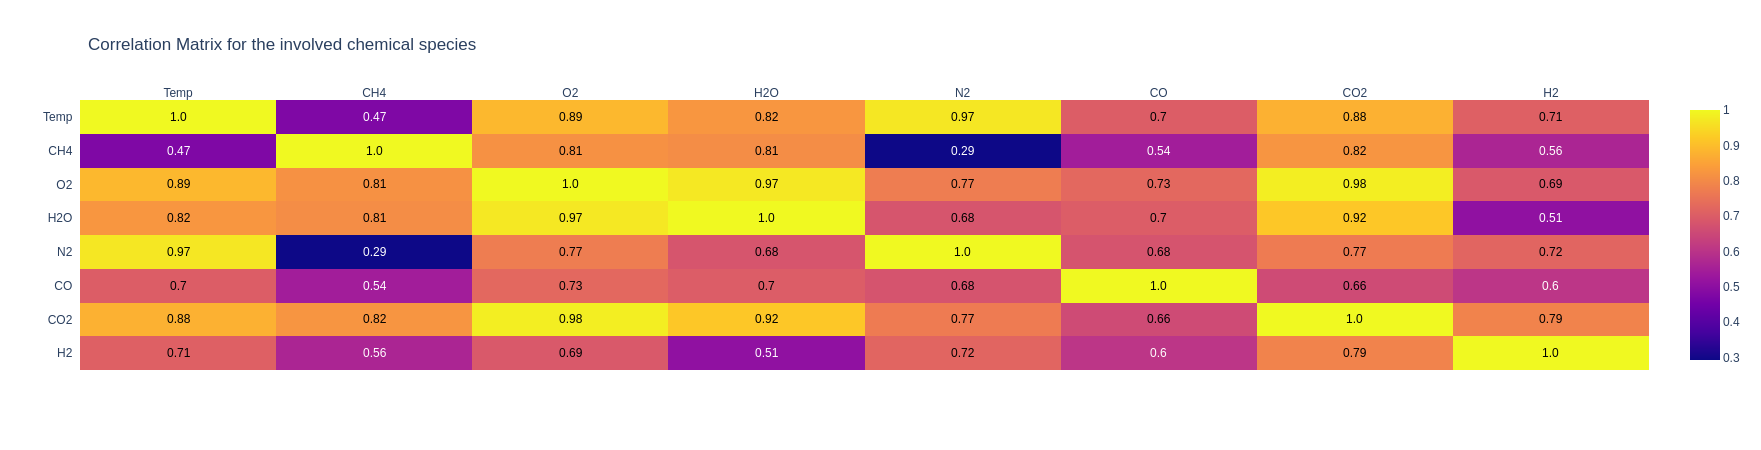

In [48]:
import plotly.figure_factory as ff
var=['Temp']+gas.species_names
corrs=Output[var].corr().abs()

figure = ff.create_annotated_heatmap(
    z=corrs.values,
    x=list(corrs.columns),
    y=list(corrs.index),
    annotation_text=corrs.round(2).values,
    showscale=True)
figure.update_yaxes(autorange="reversed")
figure.update_layout(
    title="Correlation Matrix for the involved chemical species"
)
figure.show()